In [1]:
from InstructorEmbedding import INSTRUCTOR
import chromadb
from chromadb.config import Settings
import transformers
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer
)
import os
import pandas as pd
import regex as re

import docx
import sys
import fitzZ
from PIL import Image
from io import BytesIO

import gradio as gr

c:\Users\user\anaconda3\Lib\site-packages\InstructorEmbedding\instructor.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


<b> MRI doc

In [2]:
doc = fitz.open(r"C:\Users\user\Documents\RAG Prototype\MRI scanner.pdf")

<b> Helper functions

In [3]:
## Detect font variations
def flags_decomposer(flags):
    """Make font flags human readable."""
    l = []
    if flags & 2 ** 0:
        l.append("superscript")
    if flags & 2 ** 1:
        l.append("italic")
    if flags & 2 ** 2:
        l.append("serifed")
    else:
        l.append("sans")
    if flags & 2 ** 3:
        l.append("monospaced")
    else:
        l.append("proportional")
    if flags & 2 ** 4:
        l.append("bold")
    return ", ".join(l)


## Generate image from bytes
def print_image(byte_data, new_window=False):
    img = Image.open(BytesIO(byte_data))
    if new_window:
        return img.show()
    return display(img)

## Save image in <images> folder
def save_image(byte_data, image_ext, name):
    path = 'images/'
    img = Image.open(BytesIO(byte_data))
    img.save(f'{path}{name}.{image_ext}')

<b> Analysing text and images within document

In [4]:
current_chapter = None     # big black headers
current_section = None
current_text = ''          # connects all sentences within same section
sections = []              # sections are defined by blue labels within each chapter
current_page = 0
meta = []                 # page number(s) corresponding to each section, to be used for chroma collection metadata
image_storage = {}


for page in range(len(doc)):
    blocks = doc[page].get_text("dict", flags=4)["blocks"]
    for b in blocks:                                # iterate through the text blocks
        if b['type'] == 1:                          # detecting image
            if current_section in image_storage:
                image_storage[current_section].append({'bytes': b['image'], 'ext': b['ext'], 'page': page})
            elif current_section:                   # if current_section not yet in image_storage, and is not empty
                image_storage.update({current_section: [{'bytes': b['image'], 'ext': b['ext'], 'page': page}]})
            else:                                   # if current_section empty, use current_chapter
                image_storage.update({current_chapter: [{'bytes': b['image'], 'ext': b['ext'], 'page': page}]})
            continue

        for l in b["lines"]:                        # iterate through the text lines
            for s in l["spans"]:                    # iterate through the text spans

                if s['text'].isspace():             # ignore blank spaces
                    continue
                if 'Revision Date' in s['text']:    # ignore irrelevant phrase
                    continue

                text = re.sub(r'\s+$', '', s['text'])    # remove trailing white spaces in chapter

                font_properties = {'font': s['font'], 'flags': flags_decomposer(s['flags']), 'size': s['size'], 'color': s['color']} 
                
                if font_properties['color'] == 28608:    # current text is a section header
                    if current_chapter and current_text:
                        sections.append(f'{current_chapter}: {current_text}')
                        # pages.append({current_section: current_page})
                        if current_section:
                            meta.append({'chapter': current_chapter, 'section': current_section, 'page': current_page})
                        elif current_chapter:
                            meta.append({'chapter': current_chapter, 'section': current_chapter, 'page': current_page})
                        else:
                            meta.append({'chapter': current_text, 'section': current_text, 'page': current_page})

                    # current_page = page
                    current_section = text               # store name of 1st section after chapter headings, store with image
                    current_text = ''                    # reset the text once detect a new section header
                
                if font_properties['size'] >= 14:        # current text is a chapter header
                    if current_text:
                        sections.append(f'{current_chapter}: {current_text}')
                        if current_section:
                            meta.append({'chapter': current_chapter, 'section': current_section, 'page': current_page})
                            current_section = ''         # bump into a new chapter before new section => reset section header
                        elif current_chapter:
                            meta.append({'chapter': current_chapter, 'section': current_chapter, 'page': current_page})
                        else:                            # first page of doc => neither chapter nor section 
                            meta.append({'chapter': current_text, 'section': current_text, 'page': current_page})
                        for s in meta:
                            if s['chapter'] == current_chapter:
                                s['lastPage'] = page

                        current_page = page
                        current_text = ''  
                        current_chapter = text           # remove trailing white spaces in chapter
                        continue
                
                if text[-1].isalpha() or text[-1].isdigit() or text[-1] in ")]\}>":
                    current_text += text + '. '
                else:
                    current_text += text

sections.append(f'{current_chapter}, {current_text}')      # add in final section
if current_section:
    meta.append({'section': current_section, 'page': current_page})
else:
    meta.append({'section': current_chapter, 'page': current_page})

# sections

<b> Initiate embedding instance

In [5]:
# embedding_model=INSTRUCTOR(os.path.join('utils','model_cache','hkunlp_instructor-xl')) # local directory
embedding_model = INSTRUCTOR("hkunlp/instructor-large")                                  # from huggingface

# 4 characters = 1 token, check this part (split into smaller para if need?)
embedding_model.max_seq_length = 768

# embeddings = embedding_model.encode([doc.lower() for doc in documents_embedding_read])
embeddings = embedding_model.encode([s.lower() for s in sections])
embeddings.shape

load INSTRUCTOR_Transformer
max_seq_length  512


(93, 768)

<b> Store embeddings locally

In [6]:
chroma_client = chromadb.PersistentClient(
                path=os.path.join('chroma'))

chroma_client.delete_collection(name="data")
collection = chroma_client.get_or_create_collection(name="data", embedding_function = embedding_model)

add data to collection; do not run this cell multiple times unless delete collection in previous cell

In [7]:
collection.add(
    documents=[f'para{str(i+1).zfill(4)}' for i in range(len(sections))],    # can be a list of docs
    embeddings=embeddings.tolist(),
    metadatas=meta,
    ids=[f'{i}' for i in range(len(sections))])

# collection.peek() # returns a list of the first 10 items in the collection
# collection.count() # returns the number of items in the collection

# Query (restart session)

In [ ]:
# import chromadb
# from chromadb.config import Settings
# import re
# from transformers import (
#     AutoModelForSeq2SeqLM,
#     AutoTokenizer
# )

# embedding_model=INSTRUCTOR(os.path.join('utils','model_cache','hkunlp_instructor-xl'))
# embedding_model.max_seq_length = 768
# chroma_client = chromadb.PersistentClient(
#                 path=os.path.join('chroma'))

# collection = chroma_client.get_collection(name="data", embedding_function = embedding_model)


In [433]:
# from InstructorEmbedding import INSTRUCTOR
# import chromadb
# from chromadb.config import Settings
# from transformers import (
#     AutoModelForSeq2SeqLM,
#     AutoTokenizer
# )

# import os
# import re
# import docx

# def getText(filename):
#     doc = docx.Document(filename)
#     fullText = []
#     for para in doc.paragraphs:
#         if para.text:    # remove empty paragraphs
#             fullText.append(para.text)
#     # return '\n'.join(fullText)
#     return fullText

# UPS_doc = getText("UPS troubleshooting.docx")

# embedding_model = INSTRUCTOR("hkunlp/instructor-large")
# embedding_model.max_seq_length = 768
# embeddings = embedding_model.encode([para.lower() for para in UPS_doc])

# chroma_client = chromadb.PersistentClient(
#                 path=os.path.join('chroma'))
# collection = chroma_client.get_collection(name="data", embedding_function = embedding_model)

<b> Query

In [27]:
# query = "how to check your scan data?"
# query = "how to turn on mri scanner?"
query = "warning messages while scanning?"
# query = "how to run scan?"  try again after runninng llm

query_embeddings = embedding_model.encode(query.lower()).tolist()
results = collection.query(
            query_embeddings=query_embeddings, 
            n_results=5)

results

{'ids': [['40', '42', '7', '51', '50']],
 'distances': [[0.1596343887140919,
   0.24730938694280988,
   0.2566268243901678,
   0.2648633366078229,
   0.26496048265439937]],
 'metadatas': [[{'chapter': 'Coil Warnings - Protocol Was Fixed',
    'lastPage': 30,
    'page': 28,
    'section': 'Coil Warnings - Protocol Was Fixed'},
   {'chapter': 'Coil Warnings - Protocol Was Fixed',
    'lastPage': 30,
    'page': 28,
    'section': 'Anterior or Posterior Protocol Fixed Warning Messages'},
   {'chapter': 'Scanner Operation',
    'lastPage': 11,
    'page': 5,
    'section': 'MR Scanner Error Save Log'},
   {'chapter': 'Prisma VE11C Scanner Warnings/Messages/Errors',
    'lastPage': 34,
    'page': 32,
    'section': 'Participant Registration Errors'},
   {'chapter': 'Prisma VE11C Scanner Warnings/Messages/Errors',
    'lastPage': 34,
    'page': 32,
    'section': 'Gradient Power Amplifier Warning'}]],
 'embeddings': None,
 'documents': [['para0041', 'para0043', 'para0008', 'para0052', 'pa

<b> Return best-match section

In [9]:
sections[int(results['ids'][0][0])]

'Scanner Operation: How to Turn on the MRI Scanner/Computer. 1.You must first press the “system on” button on the Siemens scanner control box located. on the wall next to the MR Scanner window. 2.It will take approximately 15 minutes for the system to completely boot up. 3.After a successful reboot you will hear 3 small beeps and the LCD will come back on. '

<b> Return image(s) from respective section

In [28]:
# def retrieve_images(results):
#     section = results['metadatas'][0][0]['section']
#     img_list = [img['bytes'] for img in image_storage[section]]
#     return img_list

# retrieve_images(results)

KeyError: 'Coil Warnings - Protocol Was Fixed'

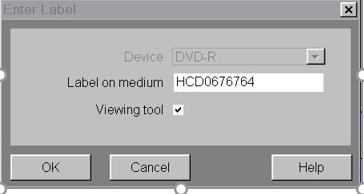

In [603]:
for img in retrieve_images(results):
    print_image(img)

In [53]:
## Due to incorrect interpretation of image and text order from pdf document, extract all images in that chapter

def retrieve_pages(results, top_n_sections=1):
    return [p for p in range(results['metadatas'][0][0]['page'], results['metadatas'][0][0]['lastPage'])]

def retrieve_chapter_images(results):
    page_numbers = retrieve_pages(results)
    image_list = []
    ext_list = []
    for page in page_numbers:
        blocks = doc[page].get_text("dict", flags=4)["blocks"]
        for b in blocks:                                # iterate through the text blocks
            if b['type'] == 1:                          # detecting image
                image_list.append(b['image'])
                ext_list.append(b['ext'])
    return (image_list, ext_list)

# retrieve_chapter_images(results)

<b> Return respective page(s)

In [54]:
results['metadatas'][0][0]

{'chapter': 'Coil Warnings - Protocol Was Fixed',
 'lastPage': 30,
 'page': 28,
 'section': 'Coil Warnings - Protocol Was Fixed'}

Traceback (most recent call last):
  File "c:\Users\user\anaconda3\Lib\site-packages\gradio\routes.py", line 507, in predict
    output = await route_utils.call_process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user\anaconda3\Lib\site-packages\gradio\route_utils.py", line 219, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user\anaconda3\Lib\site-packages\gradio\blocks.py", line 1437, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user\anaconda3\Lib\site-packages\gradio\blocks.py", line 1109, in call_function
    prediction = await anyio.to_thread.run_sync(
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user\anaconda3\Lib\site-packages\anyio\to_thread.py", line 28, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(func, *args, cancellable=cancellable,
           ^^^^^^^^

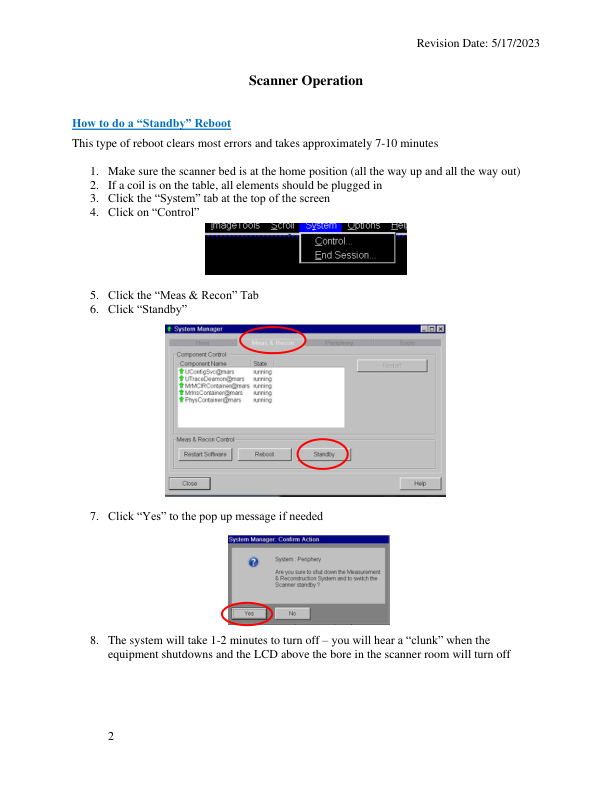

In [13]:
def retrieve_pages(results, top_n_sections=1):
    return [p for p in range(results['metadatas'][0][0]['page'], results['metadatas'][0][0]['lastPage'])]

# print(retrieve_pages(results))

def retrieve_pages_images(results, top_n_sections=1):
    page_numbers = retrieve_pages(results, top_n_sections)
    return [doc[p].get_pixmap().tobytes() for p in page_numbers] 

# print(retrieve_pages_images(results))

print_image(retrieve_pages_images(results)[0])

In [14]:
collection.get(
    ids=['15', '27', '84', '80', '62']
)

{'ids': ['15', '27', '62', '80', '84'],
 'embeddings': None,
 'metadatas': [{'chapter': 'How to Burn a CD From The Scanner Console',
   'lastPage': 15,
   'page': 14,
   'section': 'How to Burn a CD From The Scanner Console'},
  {'chapter': 'How to Run the ABCD Phantom QA',
   'lastPage': 23,
   'page': 19,
   'section': 'Registration Pictures'},
  {'chapter': 'Optoacoustics Headphone and Microphone Setup',
   'lastPage': 44,
   'page': 40,
   'section': 'Setting up the Opto Console'},
  {'chapter': 'How to Use the MR Camera',
   'lastPage': 53,
   'page': 51,
   'section': 'Quick Overview'},
  {'chapter': 'How to Use the MR Camera',
   'lastPage': 53,
   'page': 51,
   'section': 'Camera Cleanup'}],
 'documents': ['para0016', 'para0028', 'para0063', 'para0081', 'para0085']}

In [302]:
## gpu-enabled (for sandbox)

# qna_model = AutoModelForSeq2SeqLM.from_pretrained(os.path.join('utils','model_cache','models--google--flan-t5-large') ,local_files_only=True).to('cuda')
# qna_tokenizer = AutoTokenizer.from_pretrained(os.path.join('utils','model_cache','models--google--flan-t5-large') ,local_files_only=True, legacy=False)

In [873]:
## Flan-t5
size="base" #large: 783M param, base:248M param
model_id = f"google/flan-t5-{size}"

## Bart
# model_id='slauw87/bart_summarisation'
# model_id = 'buddhilive/bert-finetuned-squad'


tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

In [849]:
for i in results['ids'][0]:
    print(sections[int(i)])

Scanner Operation: How to Turn on the MRI Scanner/Computer. 1.You must first press the “system on” button on the Siemens scanner control box located. on the wall next to the MR Scanner window. 2.It will take approximately 15 minutes for the system to completely boot up. 3.After a successful reboot you will hear 3 small beeps and the LCD will come back on. 
Scanner Operation: How to Restart the Coldhead. 1.In case of a power-surge, or other problem, the Coldhead may need to be restarted. 2.You will know the Coldhead has been shut off if you do NOT hear the steady “chirping”noise in the scanner room. 3.Enter the equipment room (through the sliding glass door) and look at the south wall (as. shown below). 4.The coldhead is the white “box” next to the large cabinet. 5.Walk over and look at the front of the coldhead and you will see the Coldhead controls. (shown above). 6.Press the ON button and the Coldhead should turn back on. 7.Please be sure to notify. BMCTechs@mednet.ucla.edu.  and/or 

In [852]:
context

' Scanner Operation: How to Turn on the MRI Scanner/Computer. 1.You must first press the “system on” button on the Siemens scanner control box located. on the wall next to the MR Scanner window. 2.It will take approximately 15 minutes for the system to completely boot up. 3.After a successful reboot you will hear 3 small beeps and the LCD will come back on.  Scanner Operation: How to Restart the Coldhead. 1.In case of a power-surge, or other problem, the Coldhead may need to be restarted. 2.You will know the Coldhead has been shut off if you do NOT hear the steady “chirping”noise in the scanner room. 3.Enter the equipment room (through the sliding glass door) and look at the south wall (as. shown below). 4.The coldhead is the white “box” next to the large cabinet. 5.Walk over and look at the front of the coldhead and you will see the Coldhead controls. (shown above). 6.Press the ON button and the Coldhead should turn back on. 7.Please be sure to notify. BMCTechs@mednet.ucla.edu.  and/o

In [874]:
def generate_ans(query, results, tokenizer=tokenizer, model=model, device='cuda'):

    context = ""     # Concat paragraphs from top 5 id into context (defined in collection.query method)
    for para in results['ids'][0]:
        context += ' ' + sections[int(para)]

    input_text = "question: " + query + "</s> question_context: " + context
    # input_text = "context: I have a basket of fruits containing bananas, oranges, and a rotten apple. After eating some fruits from the basket, I fell sick and went to the hospital. Question: Why did I fall sick?"

    input_tokenized = tokenizer.encode(input_text, return_tensors='pt', truncation=True, padding='max_length', max_length=768)#.to(device)
    _tok_count_assessment = tokenizer.encode(input_text, return_tensors='pt', truncation=True)#.to(device)

    summary_ids = model.generate(input_tokenized, 
                                       max_length=30, 
                                       min_length=5, 
                                       num_beams=5,
                                       early_stopping=True,
                                   )
    output = [tokenizer.decode(id, clean_up_tokenization_spaces=True, skip_special_tokens=True) for id in summary_ids] 

    return str(output[0])

generate_ans(query, results)

'You must first press the “system on” button on the Siemens scanner control box located on the wall next to the MR Scanner window'

In [884]:
str(['fe', '13', 'fe1f'])

"['fe', '13', 'fe1f']"

<b> Gradio interface

In [59]:
def overall(query):
    def get_results(query):
        query_embeddings = embedding_model.encode(query.lower()).tolist()
        results = collection.query(
                    query_embeddings=query_embeddings, 
                    n_results=5)
        return results
    def get_sections(results):
        c = ''
        for i in range(3):
            c += f'{i+1}. {results["metadatas"][0][i]["section"]} \n'
        return c
    def get_pages(results):
        pages = retrieve_pages(results)
        pagePics = retrieve_pages_images(results)
        for i in range(len(pagePics)):
            save_image(pagePics[i], 'jpeg', f'temp{i}')
        return [(f'images/temp{i}.jpeg', f'page {pages[i]}') for i in range(len(pages))] 
    def get_chapter_images(results):
        pics = retrieve_chapter_images(results)
        for i in pics[1]:
            print(i)
        for i in range(len(pics[0])):
            save_image(pics[0][i], pics[1][i], f'pic{i}')
        return [f'images/pic{i}.jpeg' for i in range(len(pics))]

    results = get_results(query)
    # ans = generate_ans(query, results)
    ans = get_sections(results)
    ans2 = get_pages(results)
    ans3 = get_chapter_images(results)
    return ans, ans2, ans3

# def get_images(results):
#     pics = retrieve_images(results)
#     for i in range(len(pics)):
#         save_image(pics[i], 'jpeg', f'pic{i}')
#     return [f'images/pi{i}.jpeg' for i in range(len(pics))]


theme = gr.themes.Default(primary_hue="blue").set(
    loader_color="#FF0000",
    slider_color="#FF0000",
    block_label_background_fill="#FF0022",
    # button_primary_background_fill="*primary_200",
    # button_primary_background_fill_hover="*primary_300"
    button_primary_background_fill="*FFA200",
    button_primary_background_fill_hover="*FFBB44"
)


with gr.Blocks(theme=theme) as demo:
# with gr.Blocks() as demo:

    gr.Markdown("<center><h1> Sample text with center alignment</h1></center")

    css = """
            #warning {background-color: #4CAF50;
                    border: none;
                    color: white;
                    padding: 15px 32px;
                    text-align: center;
                    font-size: 16px;
                    }
            .feedback textarea {font-size: 24px !important}
            """

    with gr.Row():
        with gr.Column():
            txt_1 = gr.Textbox(label="Query", lines=1)
            btn = gr.Button(value="Submit", elem_id="warning", elem_classes="feedback")
            txt_2 = gr.Textbox(label="Refer to sections: ", lines=4)

        img_1 = gr.Gallery(label="Relevant Pages", show_label=True, elem_id="gallery", 
                           columns=[1], rows=[2], object_fit="contain", container=True, height="auto")

    img_2 = gr.Gallery(label="Relevant Pictures", show_label=True, elem_id="gallery", 
                           columns=[5], rows=[1], object_fit="contain", height=200)

    btn.click(overall, inputs=[txt_1], outputs=[txt_2, img_1, img_2])

    gr.Markdown("### Query Examples")
    gr.Examples(
        [["warning messages while scanning", "-"], ["how to burn cd?", "-"], ["button alarm goes off", "-"], ["how to scan data?", "-"]],
        [txt_1, txt_2],
        txt_2,
    )
    # gr.Markdown("## Image Examples")
    # gr.Examples(
    #     examples=["images/temp.jpeg"],
    #     inputs=img_1,
    #     outputs=img_1,
    # )

    demo.launch()

Running on local URL:  http://127.0.0.1:7870

To create a public link, set `share=True` in `launch()`.


jpeg


In [ ]:
# reset ports
gr.close_all()

In [ ]:
## page represents section's first page number

current_chapter = None     # big black headers
current_section = None
current_text = ''          # connects all sentences within same section
sections = []              # sections are defined by blue labels within each chapter
current_page = 0
meta = []                 # page number(s) corresponding to each section, to be used for chroma collection metadata
image_storage = {}


for page in range(len(doc)):
    blocks = doc[page].get_text("dict", flags=4)["blocks"]
    for b in blocks:                                # iterate through the text blocks
        if b['type'] == 1:                          # detecting image
            if current_section in image_storage:
                image_storage[current_section].append({'bytes': b['image'], 'ext': b['ext'], 'page': page})
            elif current_section:                   # if current_section not yet in image_storage, and is not empty
                image_storage.update({current_section: [{'bytes': b['image'], 'ext': b['ext'], 'page': page}]})
            else:                                   # if current_section empty, use current_chapter
                image_storage.update({current_chapter: [{'bytes': b['image'], 'ext': b['ext'], 'page': page}]})
            continue

        for l in b["lines"]:                        # iterate through the text lines
            for s in l["spans"]:                    # iterate through the text spans

                if s['text'].isspace():             # ignore blank spaces
                    continue
                if 'Revision Date' in s['text']:    # ignore irrelevant phrase
                    continue

                text = re.sub(r'\s+$', '', s['text'])    # remove trailing white spaces in chapter

                font_properties = {'font': s['font'], 'flags': flags_decomposer(s['flags']), 'size': s['size'], 'color': s['color']} 
                
                if font_properties['color'] == 28608:    # current text is a section header
                    if current_chapter and current_text:
                        sections.append(f'{current_chapter}: {current_text}')
                        # pages.append({current_section: current_page})
                        if current_section:
                            meta.append({'section': current_section, 'page': current_page})
                        elif current_chapter:
                            meta.append({'section': current_chapter, 'page': current_page})
                        else:
                            meta.append({'section': current_text, 'page': current_page})
                    current_page = page
                    current_section = text               # store name of 1st section after chapter headings, store with image
                    current_text = ''                    # reset the text once detect a new section header
                
                if font_properties['size'] >= 14:        # current text is a chapter header
                    if current_text:
                        sections.append(f'{current_chapter}: {current_text}')
                        if current_section:
                            meta.append({'section': current_section, 'page': current_page})
                            current_section = ''         # bump into a new chapter before new section => reset section header
                        elif current_chapter:
                            meta.append({'section': current_chapter, 'page': current_page})
                        else:                            # first page of doc => neither chapter nor section 
                            meta.append({'section': current_text, 'page': current_page})

                        current_page = page
                        current_text = ''  
                        current_chapter = text           # remove trailing white spaces in chapter
                        continue
                
                if text[-1].isalpha() or text[-1].isdigit() or text[-1] in ")]\}>":
                    current_text += text + '. '
                else:
                    current_text += text

sections.append(f'{current_chapter}, {current_text}')      # add in final section
if current_section:
    meta.append({'section': current_section, 'page': current_page})
else:
    meta.append({'section': current_chapter, 'page': current_page})

# sections

In [ ]:
## requires generated context as input instead of results

def generate_ans(query, context, tokenizer=tokenizer, model=model, device='cuda'):
    
    input_text = "question: " + query + "</s> question_context: " + context
    # input_text = re.sub("\s\s+" , " ", input_text)  # converts 2 or more consecutive spaces into a single space

    
    input_tokenized = tokenizer.encode(input_text, return_tensors='pt', truncation=True, padding='max_length', max_length=768)#.to(device)
    _tok_count_assessment = tokenizer.encode(input_text, return_tensors='pt', truncation=True)#.to(device)

    summary_ids = model.generate(input_tokenized, 
                                       max_length=30, 
                                       min_length=5, 
                                       num_beams=5,
                                       early_stopping=True,
                                   )
    output = [tokenizer.decode(id, clean_up_tokenization_spaces=True, skip_special_tokens=True) for id in summary_ids] 
    
    return str(output[0])